In [1]:
! pip install --quiet alibi-detect[torch] albumentations torchdrift

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torch.utils.data import random_split, DataLoader, TensorDataset

In [3]:
import albumentations as A
import matplotlib.pyplot as plt

In [4]:
# set random seed and device
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
# define encoder
encoder_net = nn.Sequential(
    nn.Conv2d(3, 64, 4, stride=2, padding=0),
    nn.ReLU(),
    nn.Conv2d(64, 128, 4, stride=2, padding=0),
    nn.ReLU(),
    nn.Conv2d(128, 512, 4, stride=2, padding=0),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(2048, 10)
).to(device)

In [6]:
albumentations_transform = A.Compose(
              [
                A.RandomBrightnessContrast(brightness_limit=0.5,contrast_limit=0.5,p=0.5),
                A.Blur(p=0.5),
                A.Cutout (num_holes=8, max_h_size=8, max_w_size=8, fill_value=0,  p=0.5)                
              ]
          )

/home/jupyter-vit_abhinav/.local/lib/python3.9/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


In [7]:
class Cifar10SearchDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="~/*Narasimha/EMLO/emlov2-session-11/data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]
            image=torch.tensor(image).permute(2, 0, 1)
        return image, label
train_ds=Cifar10SearchDataset(transform=albumentations_transform)

Files already downloaded and verified


In [ ]:
train_ds = torchvision.datasets.CIFAR10(root="~/*Narasimha/EMLO/emlov2-session-11/data/", train=True, transform=transforms.ToTensor(), download=True)
test_ds = torchvision.datasets.CIFAR10(root="~/*Narasimha/EMLO/emlov2-session-11/data/", train=False, transform=transforms.ToTensor())

In [8]:
batch_size = 128
num_classes = 10
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
#test_loader = DataLoader(test_ds, batch_size)

In [9]:
model = encoder_net
criterion = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

epoch ::  0


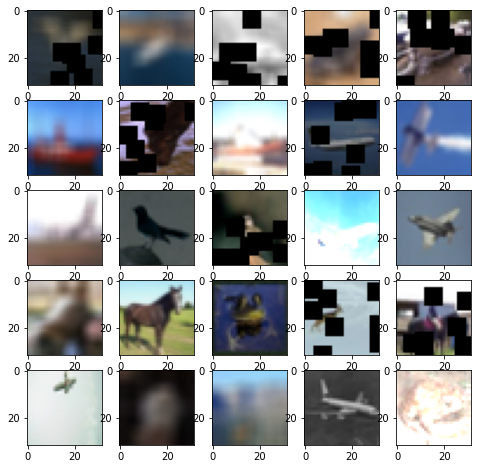

epoch ::  1


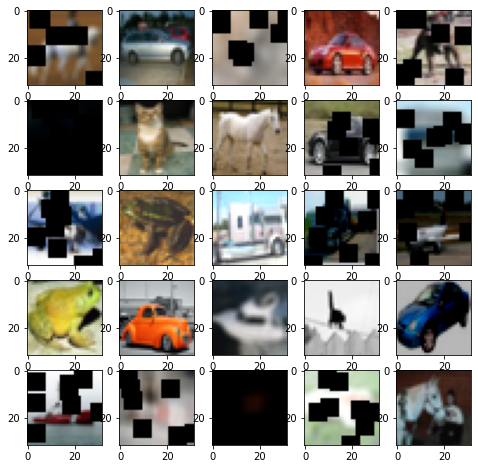

epoch ::  2


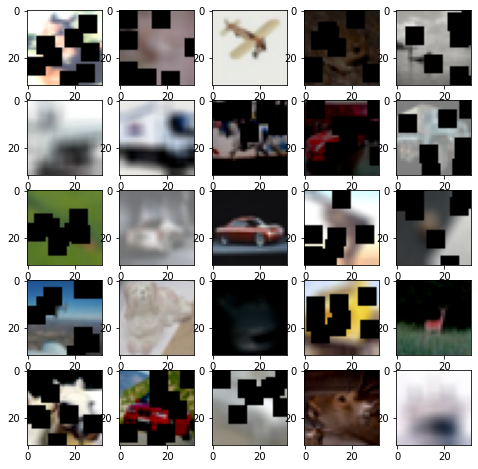

epoch ::  3


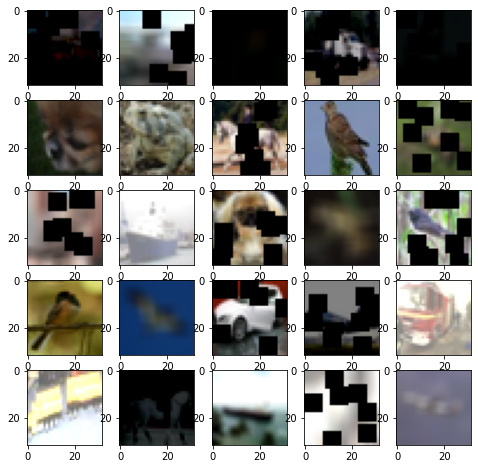

epoch ::  4


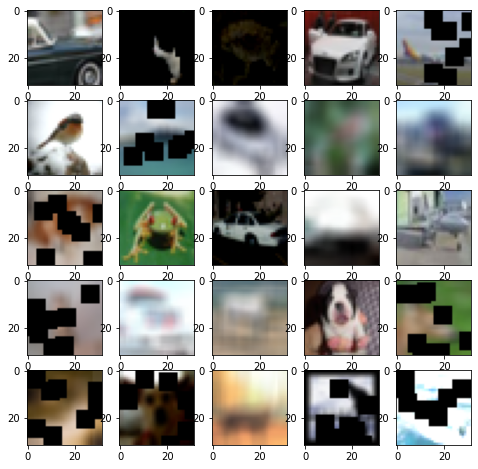

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2))
  (1): ReLU()
  (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
  (3): ReLU()
  (4): Conv2d(128, 512, kernel_size=(4, 4), stride=(2, 2))
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=2048, out_features=10, bias=True)
)

In [12]:
model.train()

for epoch in range(5):
    count=1
    w = 10
    h = 10
    fig = plt.figure(figsize=(8, 8))
    columns = 5
    rows = 5
    print("epoch :: ",epoch)
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)        
        for x in xb:
            if(count<=25):
                #plt.imshow(x.cpu())
                fig.add_subplot(rows, columns, count)
                #print("Hello",count)
                x = x.swapaxes(0,1)
                x = x.swapaxes(1,2)
                plt.imshow(x.cpu())
                count+=1
        plt.show()
        xb = xb.float()        
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
model.eval()

In [ ]:
from functools import partial
import matplotlib.pyplot as plt
import numpy as np

from alibi_detect.cd import MMDDrift
from alibi_detect.models.tensorflow import scale_by_instance
from alibi_detect.saving import save_detector, load_detector
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c
from alibi_detect.cd.pytorch import preprocess_drift

from torchvision.datasets import CIFAR10

from torch.utils.data.dataloader import DataLoader

import torchvision.transforms as T

torch.manual_seed(42)

In [ ]:
test_transforms = T.Compose([
    T.ToTensor(),
])

In [ ]:
cifar10_test_ds = CIFAR10("~/*Narasimha/EMLO/emlov2-session-11/data/", train=False, download=True, transform=test_transforms)

In [ ]:
test_ref, test_ref_h0 = torch.utils.data.random_split(cifar10_test_ds, (5_000, 5_000), )

In [ ]:
test_ref_data, test_ref_data_h0 = next(iter(DataLoader(test_ref, batch_size=5_000, shuffle=False))), next(iter(DataLoader(test_ref_h0, batch_size=5_000, shuffle=False)))

In [ ]:
n_test = test_ref_data_h0[0].shape[0]
classes, counts_ref = np.unique(test_ref_data[1], return_counts=True)
counts_h0 = np.unique(test_ref_data_h0[1], return_counts=True)[1]
print('Class Ref H0')
for cl, cref, ch0 in zip(classes, counts_ref, counts_h0):
    print('{}     {} {}'.format(cl, cref, ch0))

We are using the trained model to detect drifts !

In [ ]:
preprocess_fn = partial(preprocess_drift, model=encoder_net, device=device, batch_size=512)

Maximum Mean Discrepancy

In [ ]:
cd = MMDDrift(test_ref_data[0], backend='pytorch', p_val=.05, preprocess_fn=preprocess_fn, n_permutations=100)

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Let's try the drift detection on the reference data

In [ ]:
cd.predict(test_ref_data_h0[0][:100])

In [ ]:
perturbed_images = []

for idx in range(100):
    perturbed_image = torch.tensor(
        albumentations_transform(
            image=test_ref_data_h0[0][idx].numpy(),
        )['image']
    )
    perturbed_images.append(perturbed_image)

perturbed_images = torch.stack(perturbed_images)
plt.imshow(perturbed_images[0].permute(1, 2, 0))

Now let's try on the perturbed data

In [ ]:
cd.predict(perturbed_images[:100])

## LSDD Drift (Least-Squares Density Difference)

In [ ]:
from alibi_detect.cd import LSDDDrift

In [ ]:
cd = LSDDDrift(test_ref_data[0], backend='pytorch', p_val=.05, preprocess_fn=preprocess_fn)

In [ ]:
cd.predict(perturbed_images[:100])

## Kernel MMD (Torch Drift)

In [ ]:
import torchdrift
import sklearn

Sometimes you are not allowed to make changes in the model, so here we can use a resnet model trained on imagenet !

In [ ]:
feature_extractor = torchvision.models.resnet18(pretrained=True)
feature_extractor.fc = torch.nn.Identity()

feature_extractor = feature_extractor.to(device)

In [ ]:
drift_detector = torchdrift.detectors.KernelMMDDriftDetector()

In [ ]:
cifar10_train_ds = CIFAR10(".", train=False, download=True, transform=test_transforms)

In [ ]:
cifar10_train_dl = DataLoader(cifar10_train_ds, batch_size=128, shuffle=False)

In [ ]:
torchdrift.utils.fit(cifar10_train_dl, feature_extractor, drift_detector)

In [ ]:
drift_detection_model = torch.nn.Sequential(
    feature_extractor,
    drift_detector
).to(device)

In [ ]:
perturbed_images.shape

Perturbed Data

In [ ]:
with torch.no_grad():
    features = feature_extractor(perturbed_images.to(device))
    score = drift_detector(features)
    score = drift_detection_model(perturbed_images.to(device))
    p_val = drift_detector.compute_p_value(features)
score, p_val

P-Value is 0 ! that means a drift !

In [ ]:
N_base = drift_detector.base_outputs.size(0)
mapper = sklearn.manifold.Isomap(n_components=2)
base_embedded = mapper.fit_transform(drift_detector.base_outputs.cpu())
features_embedded = mapper.transform(features.cpu().detach().numpy())
plt.scatter(base_embedded[:, 0], base_embedded[:, 1], s=2, c='r')
plt.scatter(features_embedded[:, 0], features_embedded[:, 1], s=4)
plt.title(f'score {score:.2f} p-value {p_val:.2f}')
plt.show()

Reference Data

In [ ]:
with torch.no_grad():
    features = feature_extractor(test_ref_data_h0[0][:100].to(device))
    score = drift_detector(features)
    p_val = drift_detector.compute_p_value(features)
score, p_val

P-Value is 0.03, not a drift

In [ ]:
N_base = drift_detector.base_outputs.size(0)
mapper = sklearn.manifold.Isomap(n_components=2)
base_embedded = mapper.fit_transform(drift_detector.base_outputs.cpu())
features_embedded = mapper.transform(features.cpu().detach().numpy())
plt.scatter(base_embedded[:, 0], base_embedded[:, 1], s=2, c='r')
plt.scatter(features_embedded[:, 0], features_embedded[:, 1], s=4)
plt.title(f'score {score:.2f} p-value {p_val:.2f}')
plt.show()